<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Description
This project uses the [consumer complaint database](https://catalog.data.gov/dataset/consumer-complaint-database).

## Data Description
The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.

## Purpose
Classify consumer complaints into predefined categories.

Classification algorithms
- Linear Support Vector Machine (LinearSVM)
- Multinomial Naive Bayes 
- Logistic Regression.

# Business Problem

<div class="alert alert-block alert-success">
<b>Business Problem:</b>  <br>
Task &nbsp;&nbsp; : Find the category of given complaint. <br>
Metric : IF-IDF <br>
Cleaning: Remove punctuations, expand contractions, etc <br>
Question: Which class the given complaint belongs to?
</div>

oad the serialized object make sure you have the 
same conda environment as it was when creating the serialized object.
</div>


**Term Frequency** : This gives how often a given word appears within a document.

$\mathrm{TF}=\frac{\text { Number of times the term appears in the doc }}{\text { Total number of words in the doc }}$

**Inverse Document Frequency**: This gives how often the word appers across the documents.
If a term is very common among documents (e.g., “the”, “a”, “is”),
then we have low IDF score.

$\mathrm{IDF}=\ln \left(\frac{\text { Number of docs }}{\text { Number docs the term appears in }}\right)$

**Term Frequency – Inverse Document Frequency TF-IDF**: 
TF-IDF is the product of the TF and IDF scores of the term.

$\mathrm{TF}-\mathrm{IDF}=\frac{\mathrm{TF}}{\mathrm{IDF}}$


In machine learning, TF-IDF is obtained from the class `TfidfVectorizer`.
It has following parameters:

- `min_df`: remove the words from the vocabulary which have occurred in less than "min_df"
number of files.
- `max_df`: remove the words from the vocabulary which have occurred in more than _{ maxdf" }
total number of files in corpus.
- `sublinear_tf`: set to True to scale the term frequency in logarithmic scale.
- `stop_words`: remove the predefined stop words in 'english':
- `use_idf`: weight factor must use inverse document frequency.
- `ngram_range`: (1,2) to indicate that unigrams and bigrams will be considered.

# Imports

In [307]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time

# random state
SEED=100

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 50)


print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.18.2'), ('pandas', '1.0.3'), ('seaborn', '0.10.0'), ('matplotlib', '3.2.1')]


In [308]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [309]:
# pyspark
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext

spark = pyspark.sql.SparkSession.builder.appName('bhishan').getOrCreate()
sc = spark.sparkContext
sqc = SQLContext(sc) # spark_df = sqlContext.createDataFrame(pandas_df)
sc.setLogLevel("INFO")

print([(x.__name__,x.__version__) for x in [np, pd, pyspark]])

[('numpy', '1.18.2'), ('pandas', '1.0.3'), ('pyspark', '2.4.5')]


In [310]:
# pyspark sql
from pyspark.sql.functions import col
from pyspark.sql.functions import udf # @udf("integer") def myfunc(x,y): return x - y
from pyspark.sql import functions as F # stddev format_number date_format, dayofyear, when
from pyspark.sql.types import StructField, StringType, IntegerType, FloatType, StructType, DateType

In [311]:
# pyspark ml feature
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import OneHotEncoder,OneHotEncoderEstimator
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [312]:
# classifiers
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [313]:
# cross validation
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel

In [314]:
# model evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

In [315]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover,HashingTF,IDF

In [316]:
from itertools import chain
from pyspark.sql.functions import create_map, lit

# Useful Scripts

In [317]:
def add_text_barplot(ax, decimals=4, rot=30,percent=False,comma=False):
    assert hasattr(ax,'patches')
    for p in ax.patches:
        txt = f"{p.get_height():,.2f}"
        txt = np.round(p.get_height(), decimals=decimals)
        
        if comma:
            if (int(txt)==txt):
                txt = "{:,}".format(int(txt))
            else:
                txt = "{:,.2f}".format(txt)
        
        txt = str(txt) + '%' if percent else txt
        x = p.get_x()+p.get_width()/2.
        y = p.get_height()
        ax.annotate(txt, (x,y), ha='center', va='center', 
                xytext=(0, 10), rotation=rot,textcoords='offset points')

In [318]:
df_eval = pd.DataFrame({
    'model_name':[],
    'desc':[],
    'f1':[],
    'weightedPrecision':[],
    'weightedRecall':[],
    'accuracy':[],
    'areaUnderROC':[],
    'areaUnderPR':[]
})

df_eval

,model_name,desc,f1,weightedPrecision,weightedRecall,accuracy,areaUnderROC,areaUnderPR


# Load the data

In [319]:
!head -1 ../data/complaints_5k.csv

Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID


In [320]:
!tail -1 ../data/complaints_5k.csv

# all the parts inside double quote "" is one part, so we need to escape " in spark.

2015-03-23,Debt collection,Mortgage,Communication tactics,Frequent or repeated calls,,,"CITIBANK, N.A.",TN,38261,,,Referral,2015-03-27,Closed with explanation,Yes,No,1295868


In [321]:
%%bash
head -8 ../data/complaints_5k.csv | cut -d ',' -f 1

# note that: we can not Naively assume comma as separator, we need to escape double quote "

Date received
2014-07-09
2017-12-02

I called this past week to check if this was done yet

As I right this complaint



In [322]:
## Read as pandas df just to verify number of rows
df_raw_pandas = pd.read_csv('../data/complaints.csv',usecols=['State'])
print(df_raw_pandas.shape)

display(df_raw_pandas.head())

del df_raw_pandas

(1592522, 1)


,State
0,FL
1,PA
2,CA
3,NC
4,FL


In [323]:
# df_raw = spark.read.option("multiline",True).csv(
#     '../data/complaints_5k.csv',
#     header=True,
#     inferSchema=True,
#     escape='"',
#     sep=',').cache()

df_raw = spark.read.option("multiline",True).csv(
    '../data/complaints.csv',
    header=True,
    inferSchema=True,
    sep=',',
    escape='"',
    multiLine=True
    ).cache()

print('nrows = ', df_raw.count(), 'ncols = ', len(df_raw.columns))

df_raw.limit(5).toPandas()

nrows =  1592522 ncols =  18


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,None,TRANSWORLD SYSTEMS INC,FL,335XX,None,Consent provided,Web,2019-09-24,Closed with explanation,Yes,N/A,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,None,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,None,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,N/A,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,None,Consent provided,Web,2019-10-25,Closed with explanation,Yes,N/A,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",None,"Diversified Consultants, Inc.",NC,275XX,None,Consent provided,Web,2019-11-08,Closed with explanation,Yes,N/A,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,None,None,HYUNDAI CAPITAL AMERICA,FL,33161,None,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,N/A,3146310


# Text Manipulation

In [324]:
df = df_raw.select('Product','Consumer complaint narrative')
df = df.withColumnRenamed('Product','product')\
       .withColumnRenamed('Consumer complaint narrative','complaint')

In [325]:
df = df.limit(10_000)
df = df.na.drop(subset=["complaint"])

In [326]:
df.show(2)

+--------------------+--------------------+
|             product|           complaint|
+--------------------+--------------------+
|     Debt collection|transworld system...|
|Credit reporting,...|I would like to r...|
+--------------------+--------------------+
only showing top 2 rows



In [327]:
df.groupby('product').count().show()

+--------------------+-----+
|             product|count|
+--------------------+-----+
|     Debt collection|  415|
|Credit reporting,...| 1038|
|Money transfer, v...|   33|
|            Mortgage|  181|
|        Student loan|   74|
|Credit card or pr...|  198|
|Vehicle loan or l...|   46|
|Checking or savin...|  134|
|         Credit card|    2|
|Payday loan, titl...|   51|
|       Consumer Loan|    2|
|         Payday loan|    2|
+--------------------+-----+



In [328]:
df.select('product').distinct().show()

+--------------------+
|             product|
+--------------------+
|     Debt collection|
|Credit reporting,...|
|Money transfer, v...|
|            Mortgage|
|        Student loan|
|Credit card or pr...|
|Vehicle loan or l...|
|Checking or savin...|
|         Credit card|
|Payday loan, titl...|
|       Consumer Loan|
|         Payday loan|
+--------------------+



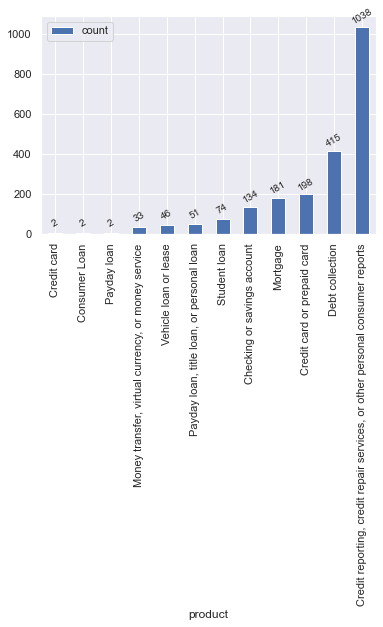

In [329]:
grp =  df.groupBy("product").count().sort("count")
ax = grp.toPandas().set_index('product').plot.bar()

add_text_barplot(ax)

In [330]:
# remove very low count categories
df = df[df.product!='Credit card']
df = df[df.product!='Payday loan']
df = df[df.product!='Consumer Loan']

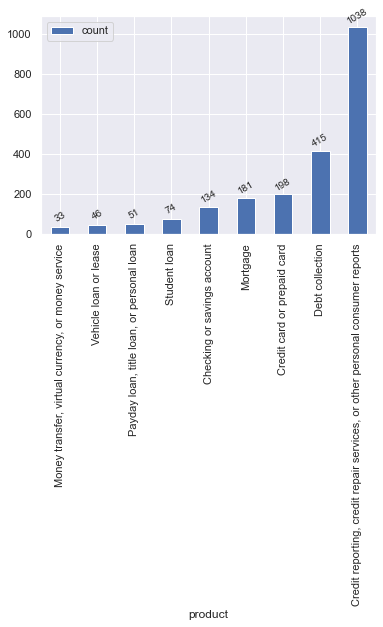

In [331]:
grp =  df.groupBy("product").count().sort("count")
ax = grp.toPandas().set_index('product').plot.bar()

add_text_barplot(ax)

# Modelling Text Data

In [332]:
df.limit(1).toPandas()

,product,complaint
0,Debt collection,transworld systems inc. \nis trying to collect...


In [333]:
ser_products = df.select('product').distinct().toPandas()
ser_products

,product
0,Debt collection
1,"Credit reporting, credit repair services, or o..."
2,"Money transfer, virtual currency, or money ser..."
3,Mortgage
4,Student loan
5,Credit card or prepaid card
6,Vehicle loan or lease
7,Checking or savings account
8,"Payday loan, title loan, or personal loan"


In [334]:
dic_id_to_products = products.to_dict()['product']
dic_id_to_products

{0: 'Debt collection',
 1: 'Credit reporting, credit repair services, or other personal consumer reports',
 2: 'Money transfer, virtual currency, or money service',
 3: 'Mortgage',
 4: 'Student loan',
 5: 'Credit card or prepaid card',
 6: 'Vehicle loan or lease',
 7: 'Checking or savings account',
 8: 'Payday loan, title loan, or personal loan'}

In [335]:
dic_products_to_id = {v:k for k,v in dic_id_to_products.items()}
dic_products_to_id

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Student loan': 4,
 'Credit card or prepaid card': 5,
 'Vehicle loan or lease': 6,
 'Checking or savings account': 7,
 'Payday loan, title loan, or personal loan': 8}

## Create Label Column

In [336]:
from itertools import chain
from pyspark.sql.functions import create_map, lit

mapping_expr = create_map([lit(x) for x in chain(*dic_products_to_id.items())])
df = df.withColumn('label', mapping_expr[df['product']])
df.show(2)

+--------------------+--------------------+-----+
|             product|           complaint|label|
+--------------------+--------------------+-----+
|     Debt collection|transworld system...|    0|
|Credit reporting,...|I would like to r...|    1|
+--------------------+--------------------+-----+
only showing top 2 rows



## Train Test Split

In [337]:
train, test = df.randomSplit([0.8, 0.2], SEED)
print("Total document count:",df.count())
print("Training-set count:",train.count())
print("Test-set count:",test.count())

Total document count: 2170
Training-set count: 1733
Test-set count: 437


## Text processing pipeline

In [338]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover,HashingTF,IDF

tokenizer = Tokenizer().setInputCol("complaint").setOutputCol("words")
remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)
hashingTF = HashingTF().setNumFeatures(1000).setInputCol("filtered").setOutputCol("rawFeatures")
idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(0)

In [339]:
print(tokenizer.explainParams())

inputCol: input column name. (current: complaint)
outputCol: output column name. (default: Tokenizer_030a39a6eaa7__output, current: words)


In [340]:
remover.getStopWords()[:2]

['i', 'me']

In [341]:
lr = LogisticRegression().setRegParam(0.01).setThreshold(0.5)
print("Logistic regression features column=",lr.getFeaturesCol())
print("logistic regression label column=",lr.getLabelCol())
print("Logistic regression threshold=",lr.getThreshold())

Logistic regression features column= features
logistic regression label column= label
Logistic regression threshold= 0.5


In [342]:
pipeline=Pipeline(stages=[tokenizer,remover,hashingTF,idf, lr])

In [343]:
model=pipeline.fit(train)

# Model Predictions

In [348]:
predictions = model.transform(test)
predictions.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             product|           complaint|label|               words|            filtered|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Checking or savin...|Ally Bank freezes...|    7|[ally, bank, free...|[ally, bank, free...|(1000,[44,48,63,6...|(1000,[44,48,63,6...|[1.71802763053932...|[0.30831345417499...|       5.0|
|Checking or savin...|BOA charges fees ...|    7|[boa, charges, fe...|[boa, charges, fe...|(1000,[4,8,18,57,...|(1000,[4,8,18,57,...|[0.70782793213555...|[0.00253995434450...|       7.0|
|Checking or savin...|Back in XXXX, I o...|    7|[back, in, xxxx,

In [357]:
predictions.select('complaint','label','prediction').sample(False,0.1,10).show(5,truncate=True)

+--------------------+-----+----------+
|           complaint|label|prediction|
+--------------------+-----+----------+
|Bank of America '...|    7|       5.0|
|I went to the ban...|    7|       0.0|
|I had a XXXX XXXX...|    5|       8.0|
|On XX/XX/19 I was...|    5|       0.0|
|Accounts added an...|    1|       1.0|
+--------------------+-----+----------+
only showing top 5 rows



# Model Evaluation Multiclass
- https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/evaluation.html

In [362]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",
                                             metricName="accuracy")
evaluator.evaluate(predictions)

0.6544622425629291

In [364]:
evaluator.save('../models/evaluator_lr.pkl')

In [365]:
evaluator = MulticlassClassificationEvaluator.load('../models/evaluator_lr.pkl')
evaluator.getPredictionCol()

'prediction'

In [363]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",
                                             metricName="f1")
evaluator.evaluate(predictions)

0.6297821526458245

# Cross Validation

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)